In [82]:
import pandas as pd
import numpy as np

data = pd.DataFrame(pd.read_csv("heart_2022_no_nans.csv"))

In [83]:
data = data.drop(columns=["State", "RaceEthnicityCategory"])
data = data.replace("Female", "0")
data = data.replace("Male", "1")
data["AgeCategory"] = data["AgeCategory"].str[4:6]

data["GeneralHealth"] = data["GeneralHealth"].replace({"Poor":"0", "Fair":"1", "Good":"2", "Very good":"3", "Excellent":"4"})
data["LastCheckupTime"] = data["LastCheckupTime"].replace({"Within past year (anytime less than 12 months ago)":"0",
                                                           "Within past 2 years (1 year but less than 2 years ago)": "1",
                                                          "Within past 5 years (2 years but less than 5 years ago)": "2",
                                                          "5 or more years ago": "3"})

data["RemovedTeeth"] = data["RemovedTeeth"].replace({"All": "3", 
                                                     "6 or more, but not all": "2",
                                                     "1 to 5": "1",
                                                     "None of them": "0"
                                                    })


data["HadDiabetes"] = data["HadDiabetes"].replace({"No":"0",
                                                  "No, pre-diabetes or borderline diabetes": "1",
                                                  "Yes, but only during pregnancy (female)": "2",
                                                  "Yes": "3"})

data["SmokerStatus"] = data["SmokerStatus"].replace({"Never smoked": "0",
                                                    "Former smoker": "1",
                                                    "Current smoker - now smokes some days": "2",
                                                    "Current smoker - now smokes every day": "3"})

data["ECigaretteUsage"] = data["ECigaretteUsage"].replace({"Never used e-cigarettes in my entire life": "0",
                                                          "Not at all (right now)": "1",
                                                          "Use them some days": "2",
                                                          "Use them every day":"3"})

data["TetanusLast10Tdap"] = data["TetanusLast10Tdap"].replace({"No, did not receive any tetanus shot in the past 10 years": "0",
                                                              "Yes, received tetanus shot but not sure what type": "1",
                                                              "Yes, received tetanus shot, but not Tdap": "2",
                                                              "Yes, received Tdap": "3"})
data["CovidPos"] = data["CovidPos"].replace({"No":"0", 
                                             "Tested positive using home test without a health professional": "1",
                                             "Yes": "2"})

data = data.replace({"No":"0",
                     "Yes": "1"})

data.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,0,3,4.0,0.0,0,1,9.0,0,0,0,...,1.60,71.67,27.99,0,0,1,1,3,0,0
1,1,3,0.0,0.0,0,1,6.0,0,0,0,...,1.78,95.25,30.13,0,0,1,1,1,0,0
2,1,3,0.0,0.0,0,0,8.0,2,0,0,...,1.85,108.86,31.66,1,0,0,1,0,0,2
3,0,1,5.0,0.0,0,1,9.0,0,0,0,...,1.70,90.72,31.32,0,0,1,1,0,0,2
4,0,2,3.0,15.0,0,1,5.0,1,0,0,...,1.55,79.38,33.07,0,0,1,1,0,0,0


## Підготовка до тренування моделей

In [84]:
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


le = LabelEncoder()
data1 = data.copy(deep = True)


col = list(data.columns)
categorical_features = []
numerical_features = []
for i in data1.columns:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        data1[i] = le.fit_transform(data1[i])
        categorical_features.append(i)

In [85]:
X = data1.drop(['HadHeartAttack'], axis=1)
y = data1['HadHeartAttack']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_initial_train, X_initial_test, y_initial_train, y_initial_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

Одразу масштабуємо та розділяємо дані на набори для тренування та тестування. Балансування класів на всій множині даних призводить до витоку даних та перенавчанню моделі (особливо дерева рішень), також це завадить корректні оцінці моделі на початкових даних. Балансування класів буде відбуватись на тренувальному наборі, тестування моделей - на наборі для тестування.

### Функція валідації моделі

Модель випробовується на початкових даних. Працює як для моделі логістичної регресії, так і для моделі дерева рішень.

In [86]:
all_logreg_logs = pd.DataFrame()
all_dtree_logs = pd.DataFrame()

def validate_model(model, balancing_method_name: str):        
    global all_logreg_logs, all_dtree_logs, X_initial_test, y_initial_test
    
    if isinstance(model, LogisticRegression):
        weights = model.coef_[0]
        intercept = model.intercept_[0]
        
        logits = np.dot(X_initial_test, weights) + intercept
        probabilities = 1 / (1 + np.exp(-logits))
        y_pred_initial = (probabilities >= 0.5).astype(int)
    else:
        probabilities = model.predict_proba(X_initial_test)[:, 1]
        y_pred_initial = model.predict(X_initial_test)
    
    accuracy_initial = accuracy_score(y_initial_test, y_pred_initial)
    precision_initial = precision_score(y_initial_test, y_pred_initial)
    recall_initial = recall_score(y_initial_test, y_pred_initial)
    f1_initial = f1_score(y_initial_test, y_pred_initial)
    roc_auc_initial = roc_auc_score(y_initial_test, probabilities)
    initial_validation_log = pd.DataFrame(data=[accuracy_initial,
                                                precision_initial,
                                                recall_initial,
                                                f1_initial,
                                                roc_auc_initial],
                                          index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
                                          columns=[f"{balancing_method_name}"])
    
    if isinstance(model, LogisticRegression):
        all_logreg_logs = pd.concat([all_logreg_logs, initial_validation_log], axis=1)
        print("\nLogistic Regression")
        print(all_logreg_logs.transpose())
    else:
        all_dtree_logs = pd.concat([all_dtree_logs, initial_validation_log], axis=1)
        print("\nDecision Tree")
        print(all_dtree_logs.transpose())

### Функції тренування моделей

Відбувається почергове тренування спочатку моделі логістичної регресії, а після й моделі дерева рішень. Після ввідбувається валідація кожної моделі та заноситься у загальний лог по всім методам та моделям.

In [87]:
def train_models(X_train_balanced, y_train_balanced, balancing_method_name: str):
    
    logreg_model = train_regression_model(X_train_balanced, y_train_balanced)
    dtree_model = train_dtree_model(X_train_balanced, y_train_balanced)

    print("\n\nComparison After Validation")
    validate_model(logreg_model, balancing_method_name)
    validate_model(dtree_model, balancing_method_name)

In [88]:
def train_regression_model(X_train_balanced, y_train_balanced):
    logreg = LogisticRegression(solver="liblinear", penalty="l2", C=0.00001, max_iter=10000)
    logreg.fit(X_train_balanced, y_train_balanced)
    
    return logreg

In [89]:
def train_dtree_model(X_train_balanced, y_train_balanced):
    dtree = DecisionTreeClassifier(random_state=0)
    dtree.fit(X_train_balanced, y_train_balanced)

    return dtree

In [90]:
# Показуємо розподіл після методу балансування
def show_stats(y_balanced, balanced_method_name):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=y_balanced, hue=y_balanced, palette="Set2")
    for container in ax.containers:
        ax.bar_label(container, label_type='center', rotation=0, color='white')
    plt.title(f"Розподіл після {balanced_method_name}", size=16)
    plt.show()

## Тренування моделей

Усього було випробовано 5 методів: Random Oversampling, SMOTE, ADASYN, K-means SMOTE, BorderLineSMOTE

### Without Sampling

Перевірка точності моделі без балансування класів. Так ми зможемо зрозуміти якщо модель після балансування класів буде менш точною.

In [91]:
train_models(X_initial_train, y_initial_train, "Without_Sampling")



Comparison After Validation

Logistic Regression
                  Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling  0.946957   0.538106  0.339898  0.416629  0.889924

Decision Tree
                  Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling   0.91259   0.257694  0.302334  0.278235  0.625469


### Random Oversampling

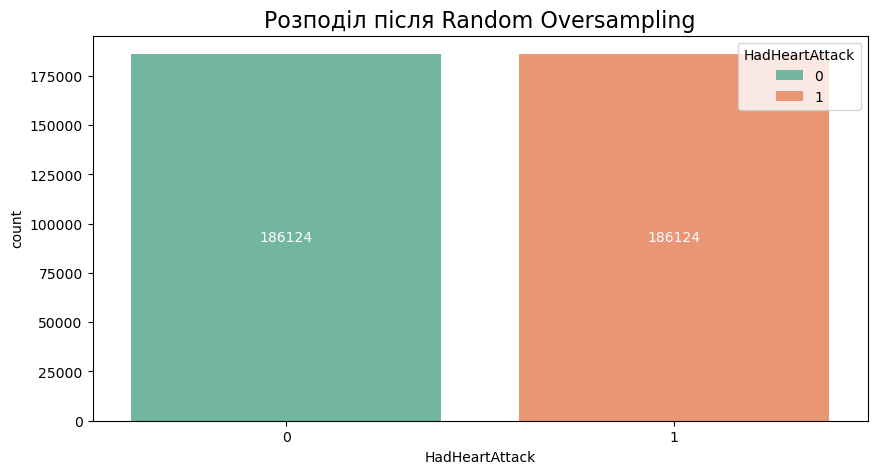

In [92]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')

X_ROS, y_ROS = oversample.fit_resample(X_initial_train, y_initial_train)

show_stats(y_ROS, "Random Oversampling")

In [93]:
train_models(X_ROS, y_ROS, "Random_Oversampling")



Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.946957   0.538106  0.339898  0.416629  0.889924
Random_Oversampling  0.755492   0.167752  0.855215  0.280486  0.891853

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.912590   0.257694  0.302334  0.278235  0.625469
Random_Oversampling  0.918728   0.267136  0.262947  0.265025  0.610188


### SMOTE

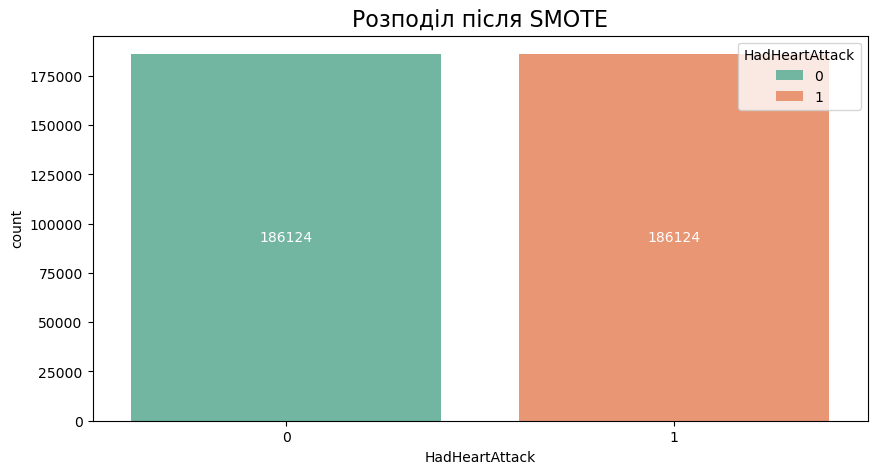

In [94]:
from  imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
import threadpoolctl

# Налаштування багатопоточності
with threadpoolctl.threadpool_limits(limits=4, user_api='blas'):
    smote = SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=NearestNeighbors(n_jobs=-1))
    X_smote, y_smote = smote.fit_resample(X_initial_train, y_initial_train)

show_stats(y_smote, "SMOTE")

In [95]:
train_models(X_smote, y_smote, "SMOTE")



Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.946957   0.538106  0.339898  0.416629  0.889924
Random_Oversampling  0.755492   0.167752  0.855215  0.280486  0.891853
SMOTE                0.749639   0.164835  0.858862  0.276587  0.891841

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.912590   0.257694  0.302334  0.278235  0.625469
Random_Oversampling  0.918728   0.267136  0.262947  0.265025  0.610188
SMOTE                0.910416   0.247729  0.298322  0.270682  0.622430


### ADASYN

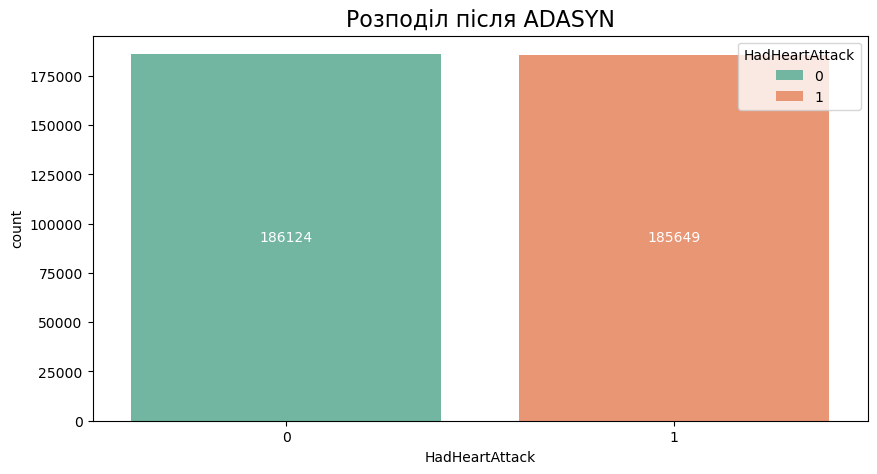

In [96]:
from  imblearn.over_sampling import ADASYN 

adasyn  = ADASYN(n_neighbors=NearestNeighbors(n_jobs=-1), random_state=0)
X_adasyn, y_adasyn = adasyn.fit_resample(X_initial_train, y_initial_train)


show_stats(y_adasyn, "ADASYN")

In [97]:
train_models(X_adasyn, y_adasyn, "ADASYN")



Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.946957   0.538106  0.339898  0.416629  0.889924
Random_Oversampling  0.755492   0.167752  0.855215  0.280486  0.891853
SMOTE                0.749639   0.164835  0.858862  0.276587  0.891841
ADASYN               0.720943   0.153366  0.886579  0.261496  0.890254

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.912590   0.257694  0.302334  0.278235  0.625469
Random_Oversampling  0.918728   0.267136  0.262947  0.265025  0.610188
SMOTE                0.910416   0.247729  0.298322  0.270682  0.622430
ADASYN               0.911635   0.256814  0.309263  0.280609  0.628224


### K-means SMOTE

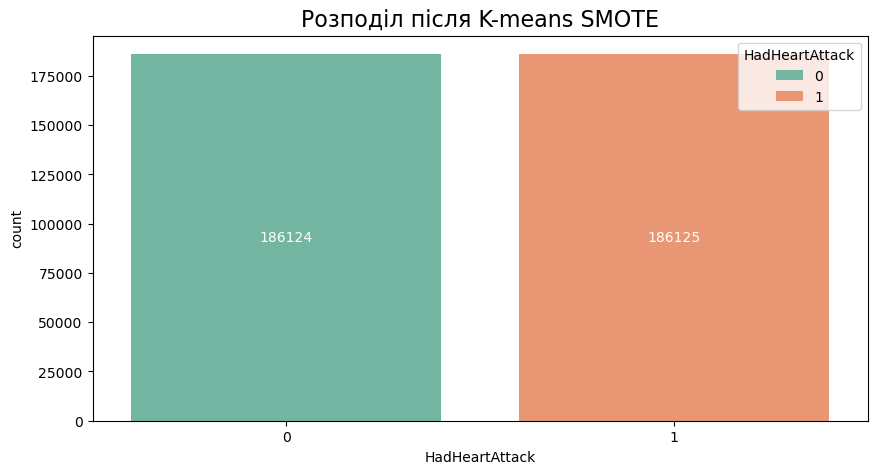

In [98]:
from  imblearn.over_sampling import KMeansSMOTE

KSMOTE  = KMeansSMOTE(cluster_balance_threshold=0.1)
X_KSMOTE, y_KSMOTE = KSMOTE.fit_resample(X_initial_train, y_initial_train)


show_stats(y_KSMOTE, "K-means SMOTE")

In [99]:
train_models(X_KSMOTE, y_KSMOTE, "K-means SMOTE")



Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.946957   0.538106  0.339898  0.416629  0.889924
Random_Oversampling  0.755492   0.167752  0.855215  0.280486  0.891853
SMOTE                0.749639   0.164835  0.858862  0.276587  0.891841
ADASYN               0.720943   0.153366  0.886579  0.261496  0.890254
K-means SMOTE        0.808028   0.195826  0.787017  0.313617  0.882700

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.912590   0.257694  0.302334  0.278235  0.625469
Random_Oversampling  0.918728   0.267136  0.262947  0.265025  0.610188
SMOTE                0.910416   0.247729  0.298322  0.270682  0.622430
ADASYN               0.911635   0.256814  0.309263  0.280609  0.628224
K-means SMOTE        0.911980   0.258143  0.309263  0.281400  0.628406


### BorderLine SMOTE

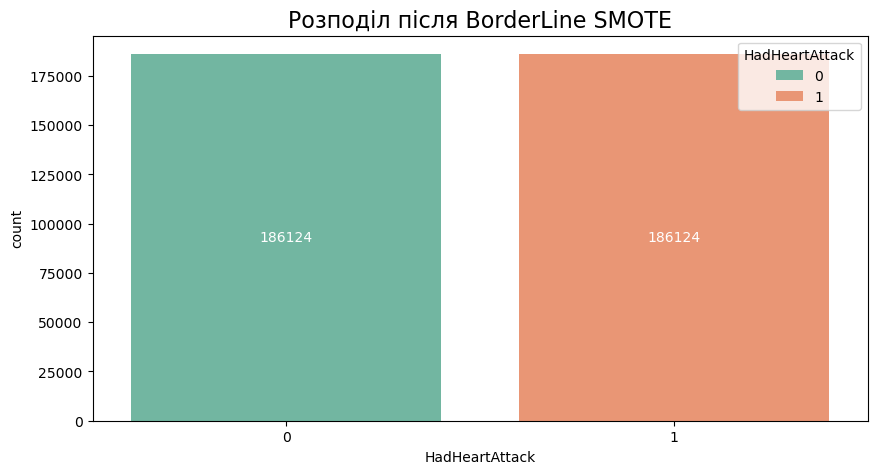

In [100]:
from imblearn.over_sampling import BorderlineSMOTE


borderline_smote = BorderlineSMOTE(sampling_strategy='auto', random_state=0)
X_BSMOTE, y_BSMOTE = borderline_smote.fit_resample(X_initial_train, y_initial_train)

show_stats(y_BSMOTE, "BorderLine SMOTE")

In [101]:
train_models(X_BSMOTE, y_BSMOTE, "BorderLine SMOTE")



Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.946957   0.538106  0.339898  0.416629  0.889924
Random_Oversampling  0.755492   0.167752  0.855215  0.280486  0.891853
SMOTE                0.749639   0.164835  0.858862  0.276587  0.891841
ADASYN               0.720943   0.153366  0.886579  0.261496  0.890254
K-means SMOTE        0.808028   0.195826  0.787017  0.313617  0.882700
BorderLine SMOTE     0.781587   0.181152  0.829322  0.297352  0.891520

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.912590   0.257694  0.302334  0.278235  0.625469
Random_Oversampling  0.918728   0.267136  0.262947  0.265025  0.610188
SMOTE                0.910416   0.247729  0.298322  0.270682  0.622430
ADASYN               0.911635   0.256814  0.309263  0.280609  0.628224
K-means SMOTE        0.911980   0.258143  0.309263  0.281400  0.628406
BorderLine 

### Висновок

З результатів порівняння моделей логістичної регресії та дерева рішень при різних методах балансування даних я можу зробити кілька висновків:
1. Модель дерева рішень погано працює при усіх випробуваних методиках балансування. AUC близько 0.6 для усіх методів показує точність передбачення лиш трохи краще за випадкову. Також, з низького показника Precision (0.2-0.25) можна сказати, що дерево рішень дуже погано передбачає позитивні випадки (серцевий напад). Тобто у 8 з 10 випадках модель передбачить серцевий напад там, де його немає.
2. Логістична регресія краще впоралась з передбаченням, але жоден метод балансування не зміг значно підвищити початковий AUC. Як і для дерева рішень, усі методи показали дуже низький показник Precision (0.1-0.15). Тобто 8 з 10 передбачень серцевого нападу будуть неккоректними. Хоча можна відмітити різке збільшення Recall для методу усіх методів балансування, близько 80-90% реальних серцевих нападів було правильно передбачено, але робиться це за рахунок загальної дуже великої кількості передбачень нападів, яка є набагато більше за реальний показник (через що маємо низький Precision).
3. Тестування практично усіх підходів балансування на збалансованих даних дає високу точність. Але, очевидно, це не є показником здібності моделі до узагальнення, так як тестування на початкових даних дає значно гірші результати.

Думаю, неефективність oversampling підходу для балансування класів можна пояснити у даному випадку через велику кількість змінних та великий дизбаланс класів (20 до 1), через що дуже важко створити нові реалістичні записи.

**В результаті жоден з oversampling методів балансування класів не запропонував збільшення точності моделі**.

Витягнути таблицю результатів методів після валідації на початкових даних:

In [21]:
with pd.ExcelWriter('oversampling_comparison.xlsx') as writer:
    all_logreg_logs.transpose().to_excel(writer, sheet_name='LogisticRegression', index=False)
    all_dtree_logs.transpose().to_excel(writer, sheet_name='DecisionTree', index=False)

print("Excel файл успішно створено")

Excel файл успішно створено
